# **Required Libraries:**

In [ ]:
!pip install openpyxl

# **Imports:**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# **Load the Data:**

In [ ]:
try:
    demographics_df = pd.read_excel('Telco_customer_churn_demographics.xlsx')
    location_df = pd.read_excel('Telco_customer_churn_location.xlsx')
    population_df = pd.read_excel('Telco_customer_churn_population.xlsx')
    services_df = pd.read_excel('Telco_customer_churn_services.xlsx')
    status_df = pd.read_excel('Telco_customer_churn_status.xlsx')
    main_df = pd.read_excel('Telco_customer_churn.xlsx')

except FileNotFoundError as e:
    print(f"Error loading files: {e}")
    print("Please make sure the file paths are correct.")
    exit()

# **1. Initial Data Inspection**

In [ ]:
print("--- Initial Data Inspection ---")
print("\nDemographics Info:")
demographics_df.info()
print("\nLocation Info:")
location_df.info()
print("\nPopulation Info:")
population_df.info()
print("\nServices Info:")
services_df.info()
print("\nStatus Info:")
status_df.info()
print("\nMain DataFrame Info:")
main_df.info()

--- Initial Data Inspection ---

Demographics Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Customer ID           7043 non-null   object
 1   Count                 7043 non-null   int64 
 2   Gender                7043 non-null   object
 3   Age                   7043 non-null   int64 
 4   Under 30              7043 non-null   object
 5   Senior Citizen        7043 non-null   object
 6   Married               7043 non-null   object
 7   Dependents            7043 non-null   object
 8   Number of Dependents  7043 non-null   int64 
dtypes: int64(3), object(6)
memory usage: 495.3+ KB

Location Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Customer ID  7043 non-null   

# **2. Standardize Column Names and Merge DataFrames**

In [ ]:
# Standardize 'Customer ID' to 'CustomerID' for merging
demographics_df.rename(columns={'Customer ID': 'CustomerID'}, inplace=True)
location_df.rename(columns={'Customer ID': 'CustomerID'}, inplace=True)
services_df.rename(columns={'Customer ID': 'CustomerID'}, inplace=True)
status_df.rename(columns={'Customer ID': 'CustomerID'}, inplace=True)

# Drop the conflicting 'Count' columns before merging
# Drop 'Under 30' as it's redundant with 'Age'
demographics_df.drop(columns=['Count', 'Under 30'], inplace=True, errors='ignore')
location_df.drop(columns=['Count'], inplace=True, errors='ignore')
services_df.drop(columns=['Count', 'Quarter'], inplace=True, errors='ignore')
status_df.drop(columns=['Count', 'Quarter'], inplace=True, errors='ignore')

print("\n--- Merging DataFrames ---")

# Merge the primary dataframes on 'CustomerID'
merged_df = pd.merge(demographics_df, location_df, on='CustomerID', how='outer')
merged_df = pd.merge(merged_df, services_df, on='CustomerID', how='outer')
merged_df = pd.merge(merged_df, status_df, on='CustomerID', how='outer')


# Merge the population data on 'Zip Code'
merged_df = pd.merge(merged_df, population_df, on='Zip Code', how='left')


print("\nShape of the merged dataframe:", merged_df.shape)
print("\nFirst 5 rows of the merged dataframe:")
print(merged_df.head())


--- Merging DataFrames ---

Shape of the merged dataframe: (7043, 51)

First 5 rows of the merged dataframe:
   CustomerID  Gender  Age Senior Citizen Married Dependents  \
0  0002-ORFBO  Female   37             No     Yes         No   
1  0003-MKNFE    Male   46             No      No         No   
2  0004-TLHLJ    Male   50             No      No         No   
3  0011-IGKFF    Male   78            Yes     Yes         No   
4  0013-EXCHZ  Female   75            Yes     Yes         No   

   Number of Dependents        Country       State          City  ...  \
0                     0  United States  California  Frazier Park  ...   
1                     0  United States  California      Glendale  ...   
2                     0  United States  California    Costa Mesa  ...   
3                     0  United States  California      Martinez  ...   
4                     0  United States  California     Camarillo  ...   

   Satisfaction Score Customer Status  Churn Label  Churn Value Ch

# **3. Data Cleaning and Preprocessing**

In [ ]:
print("\n--- Data Cleaning and Preprocessing ---")

# Drop redundant or unnecessary columns
# The 'Quarter' columns are also redundant after merging.
columns_to_drop = ['Count', 'Country', 'State', 'Lat Long', 'ID',
                   'Quarter_x', 'Quarter_y']
merged_df.drop(columns=columns_to_drop, inplace=True, errors='ignore')


# Handle duplicate customer entries
merged_df.drop_duplicates(subset='CustomerID', keep='first', inplace=True)
print(f"\nShape after dropping duplicates: {merged_df.shape}")


# Correct data types
# 'Total Charges' may be an object type due to empty strings for new customers.
# We will convert it to numeric, coercing errors to NaN.
merged_df['Total Charges'] = pd.to_numeric(merged_df['Total Charges'], errors='coerce')


# Handle missing values
# For 'Total Charges', missing values likely represent new customers with 0 charges.
# We will fill these with 0.
merged_df['Total Charges'] = merged_df['Total Charges'].fillna(0)

# For other columns, we will inspect the number of missing values.
print("\nMissing values in each column:")
print(merged_df.isnull().sum())


# Fill missing 'Churn Category' with 'Stayed'
merged_df['Churn Category'] = merged_df['Churn Category'].fillna('Stayed')
print(f"Missing 'Churn Category' values have been replaced with 'Stayed'.")


# --- 4. Feature Engineering (Example) ---

# Convert binary categorical variables to numeric (0 or 1)
# Updated based on the available columns in merged_df
binary_cols = ['Senior Citizen', 'Married', 'Dependents', 'Referred a Friend',
             'Phone Service', 'Multiple Lines', 'Online Security', 'Online Backup',
             'Device Protection', 'Tech Support', 'Streaming TV',
             'Streaming Movies', 'Paperless Billing']

for col in binary_cols:
    if col in merged_df.columns:
        merged_df[col] = merged_df[col].apply(lambda x: 1 if x == 'Yes' else 0)


# One-Hot Encode multi-category variables
# The 'CustomerID' is an identifier and should not be encoded.
# Updated based on the available columns in merged_df
categorical_cols = ['Gender', 'Offer', 'Internet Service', 'Contract',
                    'Payment Method', 'Churn Category', 'Customer Status']

# Using pandas get_dummies for one-hot encoding
df_encoded = pd.get_dummies(merged_df, columns=categorical_cols, drop_first=True)

print("\nShape of the final, encoded dataframe:", df_encoded.shape)
print("\nFirst 5 rows of the final dataframe:")
print(df_encoded.head())

print("\nFinal DataFrame Info:")
df_encoded.info()


--- Data Cleaning and Preprocessing ---

Shape after dropping duplicates: (7043, 47)

Missing values in each column:
CustomerID                              0
Gender                                  0
Age                                     0
Senior Citizen                          0
Married                                 0
Dependents                              0
Number of Dependents                    0
City                                    0
Zip Code                                0
Latitude                                0
Longitude                               0
Referred a Friend                       0
Number of Referrals                     0
Tenure in Months                        0
Offer                                3877
Phone Service                           0
Avg Monthly Long Distance Charges       0
Multiple Lines                          0
Internet Service                        0
Internet Type                        1526
Avg Monthly GB Download                 0


# **Part 1: Exploratory & Descriptive Analysis**

--- Analysis DataFrame prepared. Starting EDA. ---


/tmp/ipython-input-4021827039.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  analysis_df['Churn Category'].fillna('Stayed', inplace=True)
/tmp/ipython-input-4021827039.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=

Saved churn reasons distribution plot.
Saved churn by gender plot.


/tmp/ipython-input-4021827039.py:47: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  analysis_df['Senior Citizen'].fillna('No', inplace=True) # Fill any potential NaNs


Saved churn by senior citizen plot.
Saved churn by contract plot.
Saved churn by internet type plot.
Saved churn by monthly charges plot.
Saved churn by tenure plot.
Saved correlation heatmap.


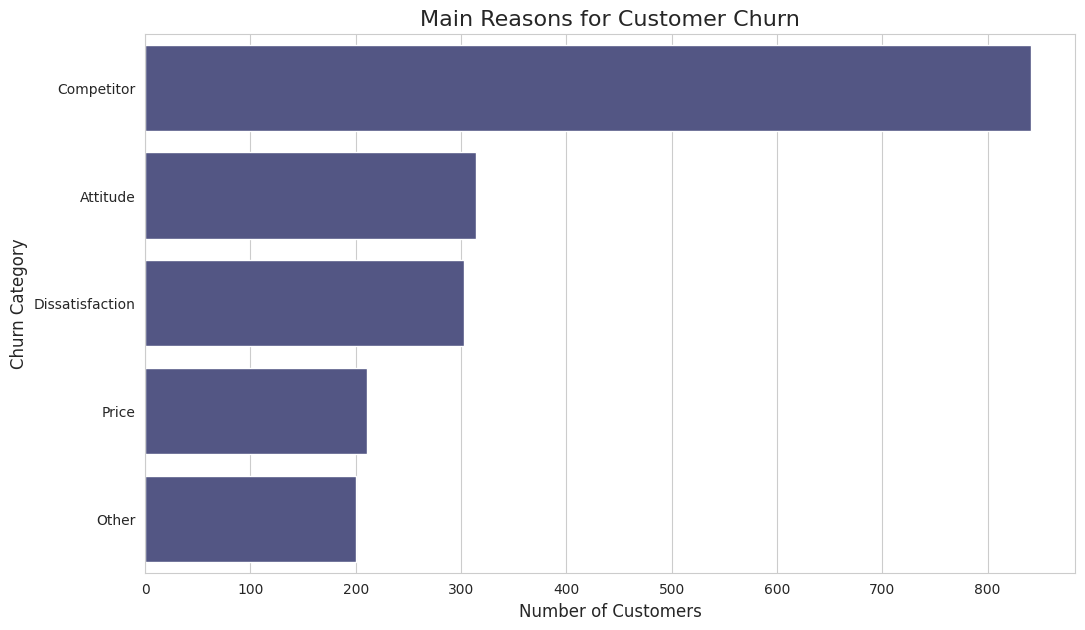

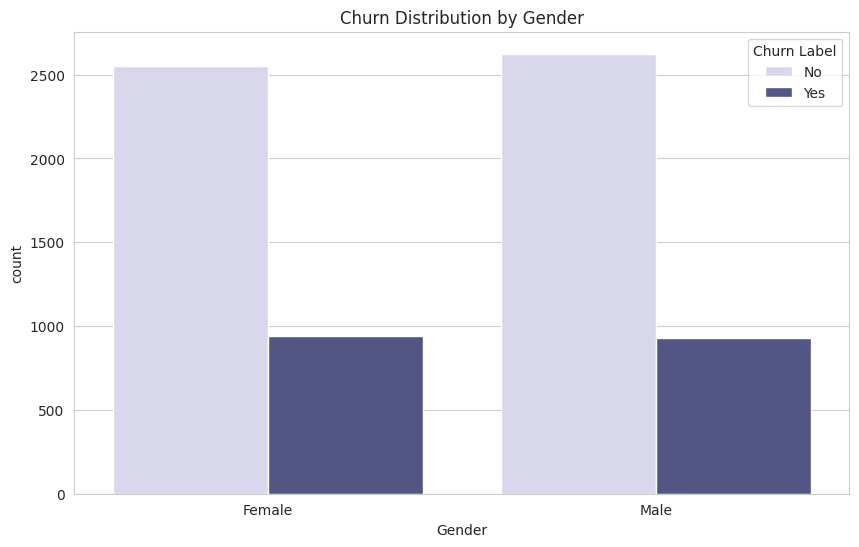

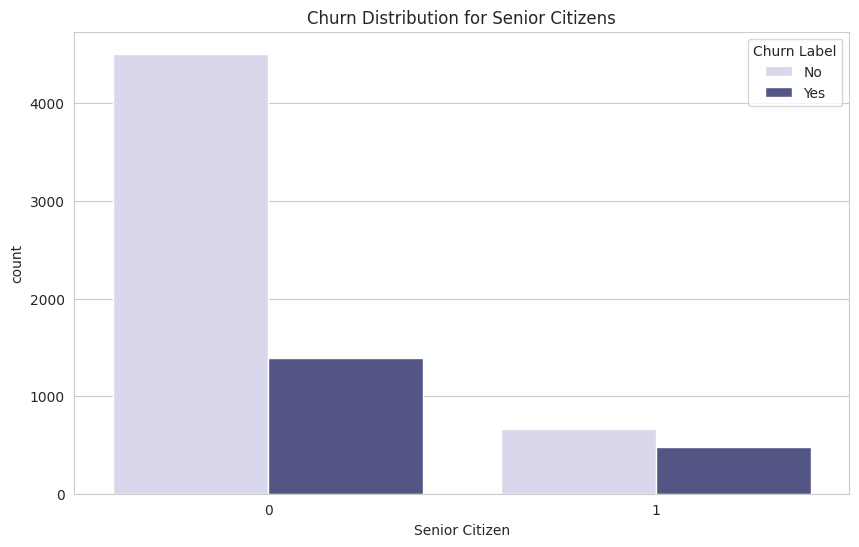

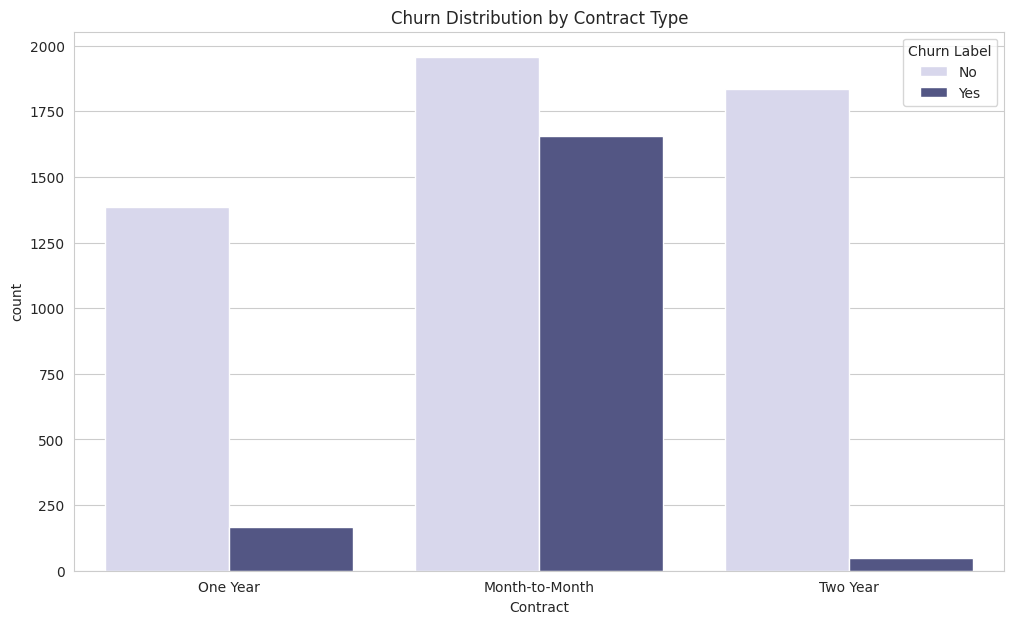

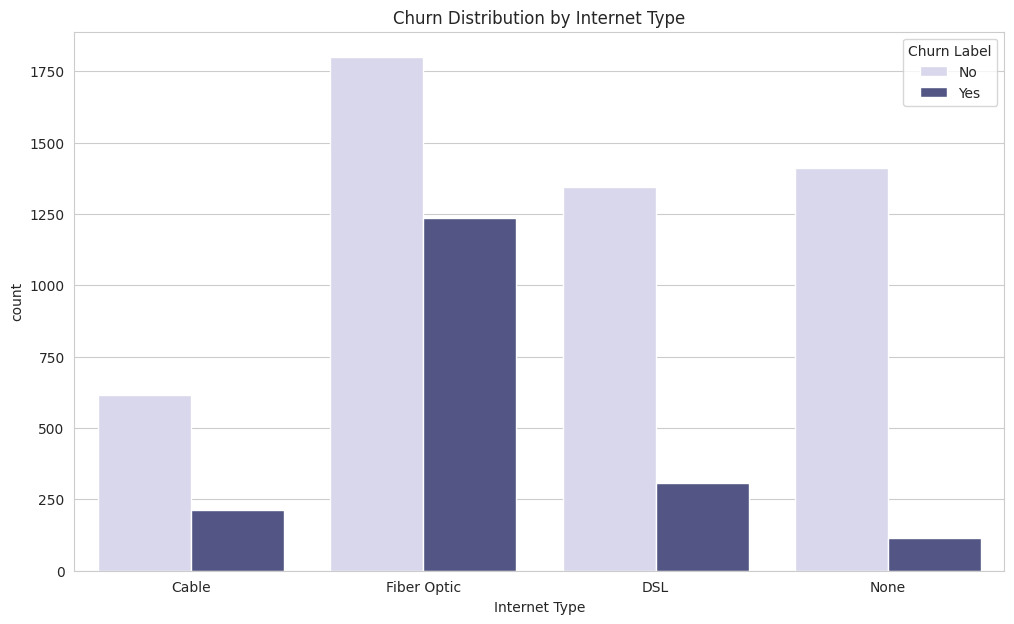

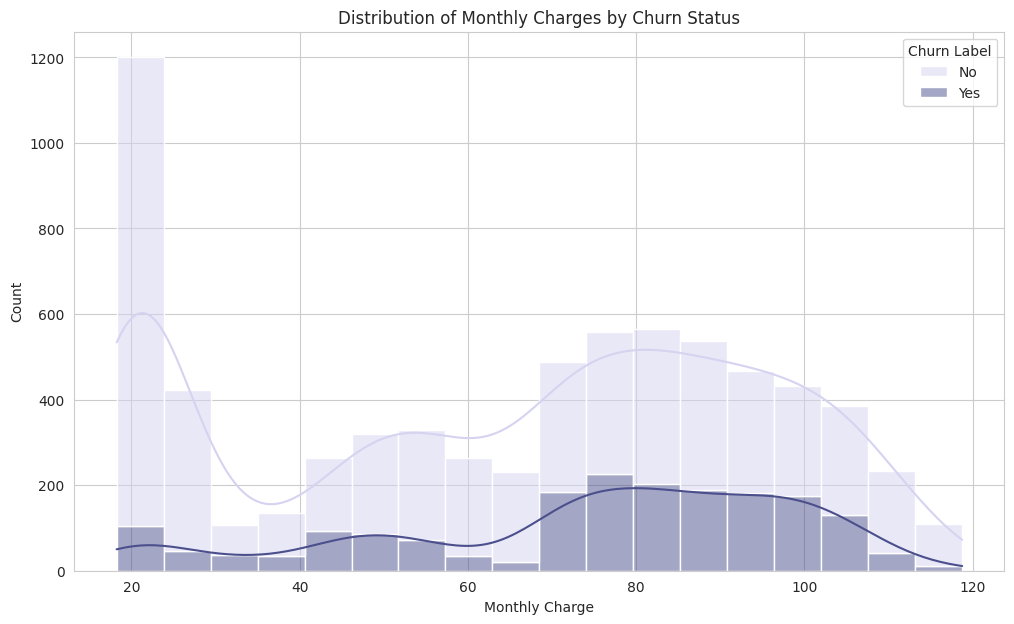

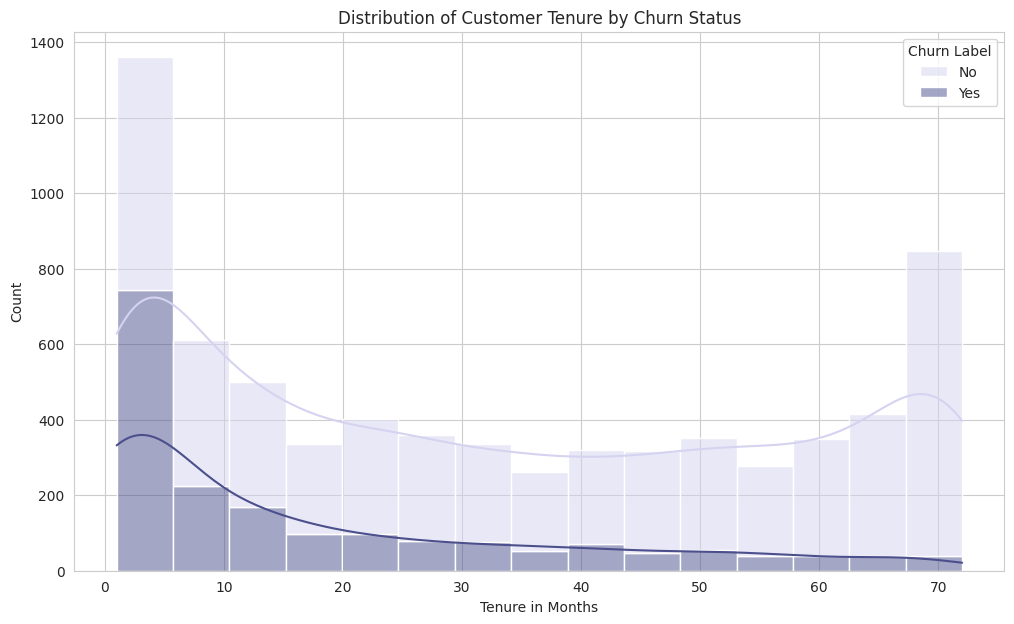

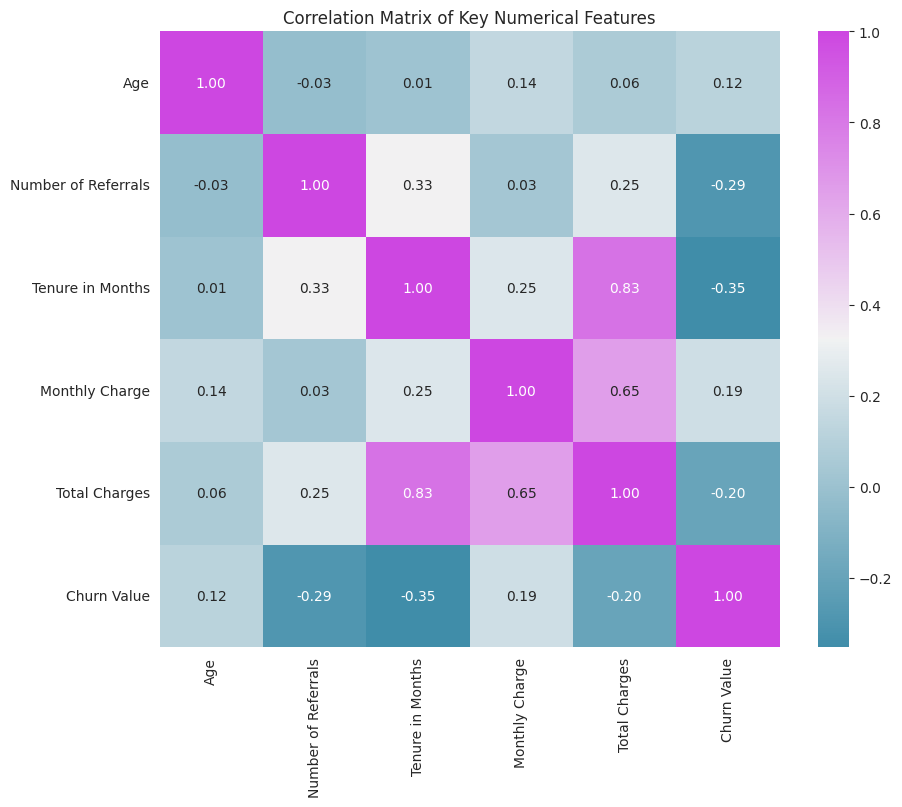

In [ ]:
# Part 1: Exploratory & Descriptive Analysis (Updated Colors)

# Import necessary libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# --- Prepare the merged_df for Analysis ---
analysis_df = merged_df.copy()
analysis_df.drop_duplicates(subset='CustomerID', keep='first', inplace=True)
analysis_df['Churn Category'].fillna('Stayed', inplace=True)
analysis_df['Churn Label'].fillna('No', inplace=True)
analysis_df['Internet Type'].fillna('None', inplace=True)
analysis_df['Churn Value'] = analysis_df['Churn Label'].apply(lambda x: 1 if x == 'Yes' else 0)


print("--- Analysis DataFrame prepared. Starting EDA. ---")

# --- Set up plot styles and custom color palette ---
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
# Define the custom color palette
churn_palette = {'Yes': '#4B4F8C', 'No': '#D5D3F0'}
primary_color = '#4B4F8C'
secondary_color = '#D5D3F0'

# --- 1. Analyze the primary reasons for customer churn ---
churn_reasons_df = analysis_df[analysis_df['Churn Category'] != 'Stayed']
plt.figure(figsize=(12, 7))
sns.countplot(data=churn_reasons_df, y='Churn Category', order=churn_reasons_df['Churn Category'].value_counts().index, color=primary_color)
plt.title('Main Reasons for Customer Churn', fontsize=16)
plt.xlabel('Number of Customers', fontsize=12)
plt.ylabel('Churn Category', fontsize=12)
plt.savefig('churn_reasons_distribution.png')
print("Saved churn reasons distribution plot.")


# --- 2. Analyze Churn by Demographics ---
# Churn by Gender
plt.figure()
sns.countplot(data=analysis_df, x='Gender', hue='Churn Label', palette=churn_palette)
plt.title('Churn Distribution by Gender')
plt.savefig('churn_by_gender.png')
print("Saved churn by gender plot.")

# Churn by Senior Citizen status
plt.figure()
analysis_df['Senior Citizen'].fillna('No', inplace=True) # Fill any potential NaNs
sns.countplot(data=analysis_df, x='Senior Citizen', hue='Churn Label', palette=churn_palette)
plt.title('Churn Distribution for Senior Citizens')
plt.savefig('churn_by_senior_citizen.png')
print("Saved churn by senior citizen plot.")


# --- 3. Analyze Churn by Contract and Services ---
# Churn by Contract Type
plt.figure(figsize=(12, 7))
sns.countplot(data=analysis_df, x='Contract', hue='Churn Label', palette=churn_palette)
plt.title('Churn Distribution by Contract Type')
plt.savefig('churn_by_contract.png')
print("Saved churn by contract plot.")

# Churn by Internet Type
plt.figure(figsize=(12, 7))
sns.countplot(data=analysis_df, x='Internet Type', hue='Churn Label', palette=churn_palette)
plt.title('Churn Distribution by Internet Type')
plt.savefig('churn_by_internet_type.png')
print("Saved churn by internet type plot.")


# --- 4. Analyze Churn by Financials (Monthly & Total Charges) ---
# Distribution of Monthly Charges for Churned vs. Stayed Customers
plt.figure(figsize=(12, 7))
sns.histplot(data=analysis_df, x='Monthly Charge', hue='Churn Label', multiple='stack', kde=True, palette=churn_palette)
plt.title('Distribution of Monthly Charges by Churn Status')
plt.savefig('churn_by_monthly_charges.png')
print("Saved churn by monthly charges plot.")

# Distribution of Tenure for Churned vs. Stayed Customers
plt.figure(figsize=(12, 7))
sns.histplot(data=analysis_df, x='Tenure in Months', hue='Churn Label', multiple='stack', kde=True, palette=churn_palette)
plt.title('Distribution of Customer Tenure by Churn Status')
plt.savefig('churn_by_tenure.png')
print("Saved churn by tenure plot.")

# --- 5. Correlation Heatmap for Numerical Features ---
analysis_df['Total Charges'] = pd.to_numeric(analysis_df['Total Charges'], errors='coerce').fillna(0)
key_features = ['Age', 'Number of Referrals', 'Tenure in Months', 'Monthly Charge', 'Total Charges', 'Churn Value']
correlation_matrix = analysis_df[key_features].corr()
# Create a custom colormap from the provided colors
custom_cmap = sns.diverging_palette(225, 300, s=80, l=55, n=9, as_cmap=True)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap=custom_cmap, fmt='.2f')
plt.title('Correlation Matrix of Key Numerical Features')
plt.savefig('correlation_heatmap.png')
print("Saved correlation heatmap.")

**Initial Findings (from EDA & Descriptive Analysis)**
Primary Churn Drivers: The biggest reason customers leave is due to competitors, followed by general dissatisfaction with the service.

Contracts are Crucial: Customers on Month-to-Month contracts are far more likely to churn than those on yearly contracts. This is a major vulnerability.

Tenure Matters: New customers (with low Tenure in Months) are at the highest risk of churning. Loyalty increases significantly over time.

Price Sensitivity: Customers with higher Monthly Charge show a higher tendency to churn. This is especially true for those with Fiber Optic service, which is typically more expensive.

Demographics: Senior Citizens appear to churn more frequently than younger customers. Gender does not seem to be a significant factor.

# **Part 2: Diagnostic Analysis**

Saved top 15 churn reasons plot.


/tmp/ipython-input-4117397161.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=churned_df, x='Monthly Charge', y='Churn Category', palette=category_palette)


Saved monthly charges by churn category plot.


/tmp/ipython-input-4117397161.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=churned_df, x='Tenure in Months', y='Churn Category', palette=category_palette)


Saved tenure by churn category plot.
Saved churn reasons by contract plot.


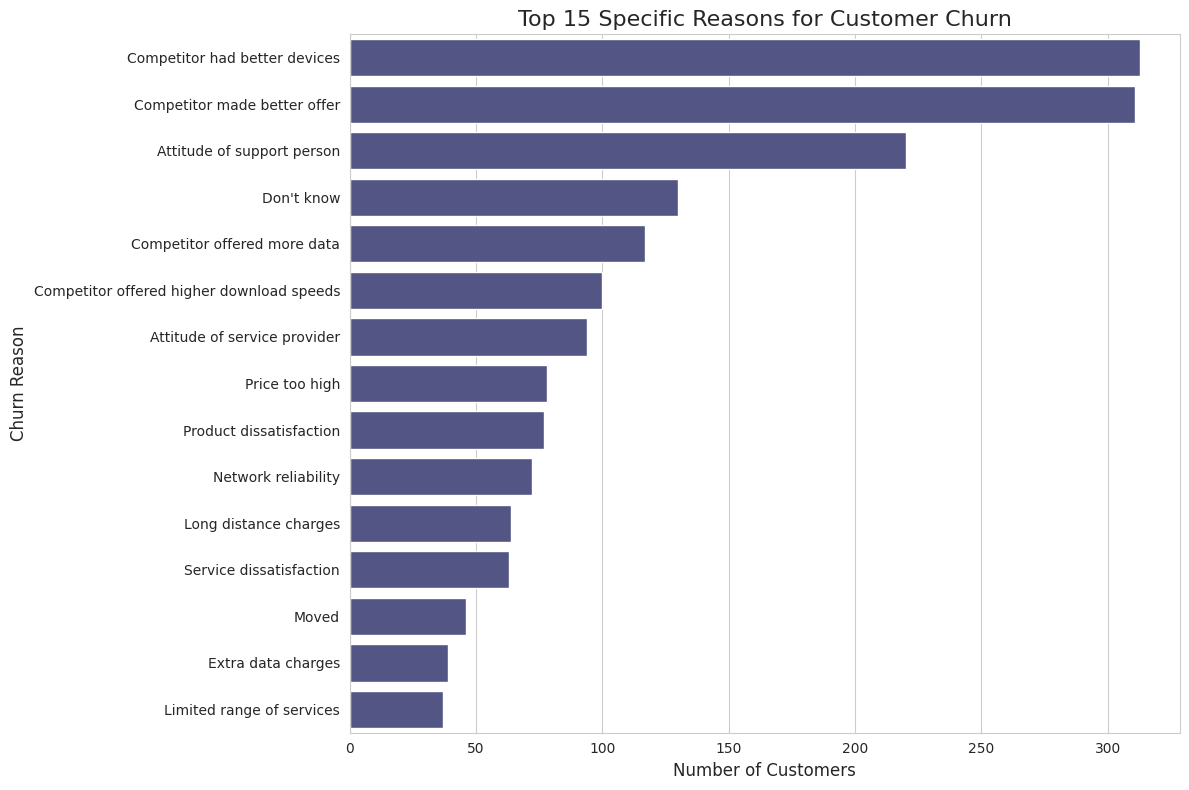

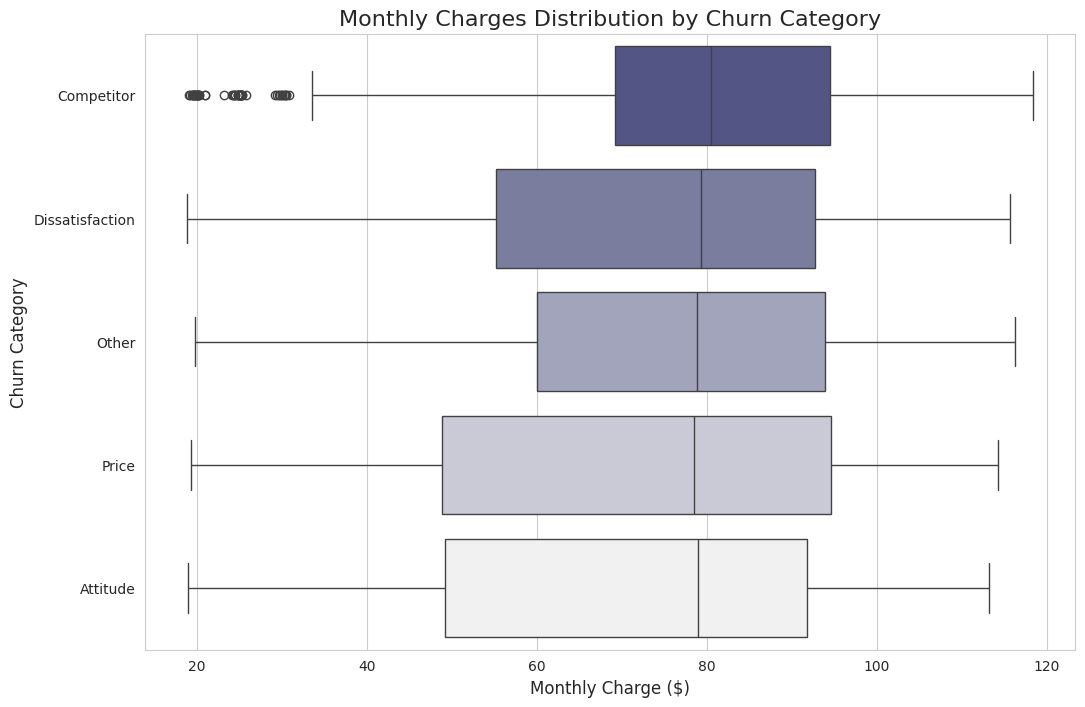

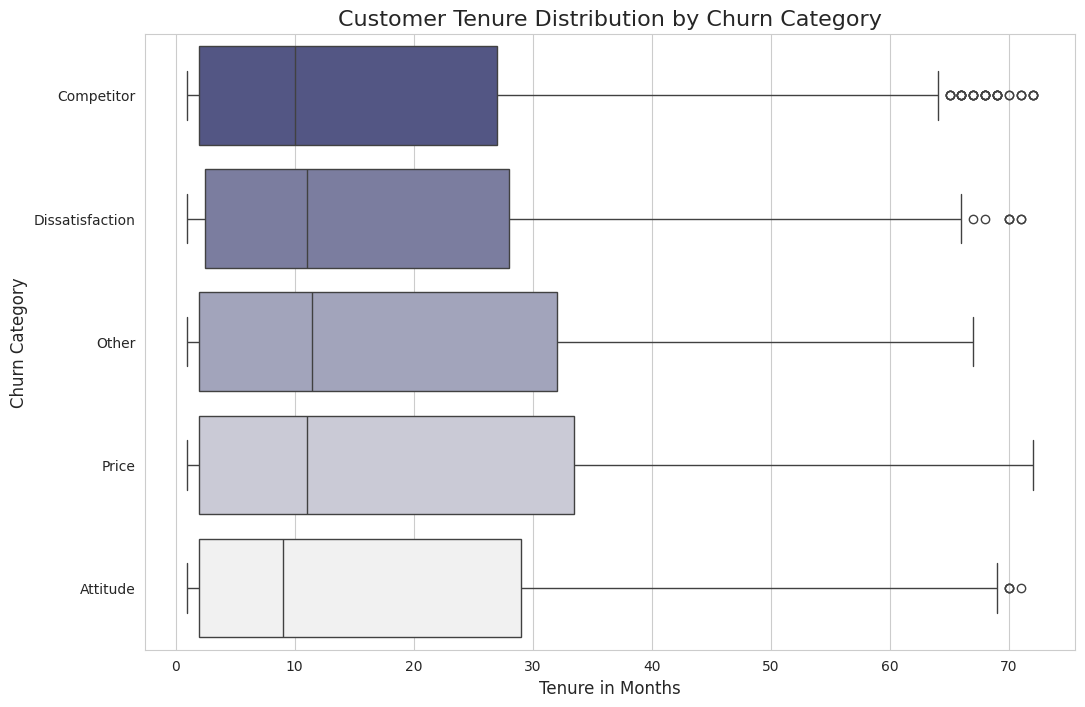

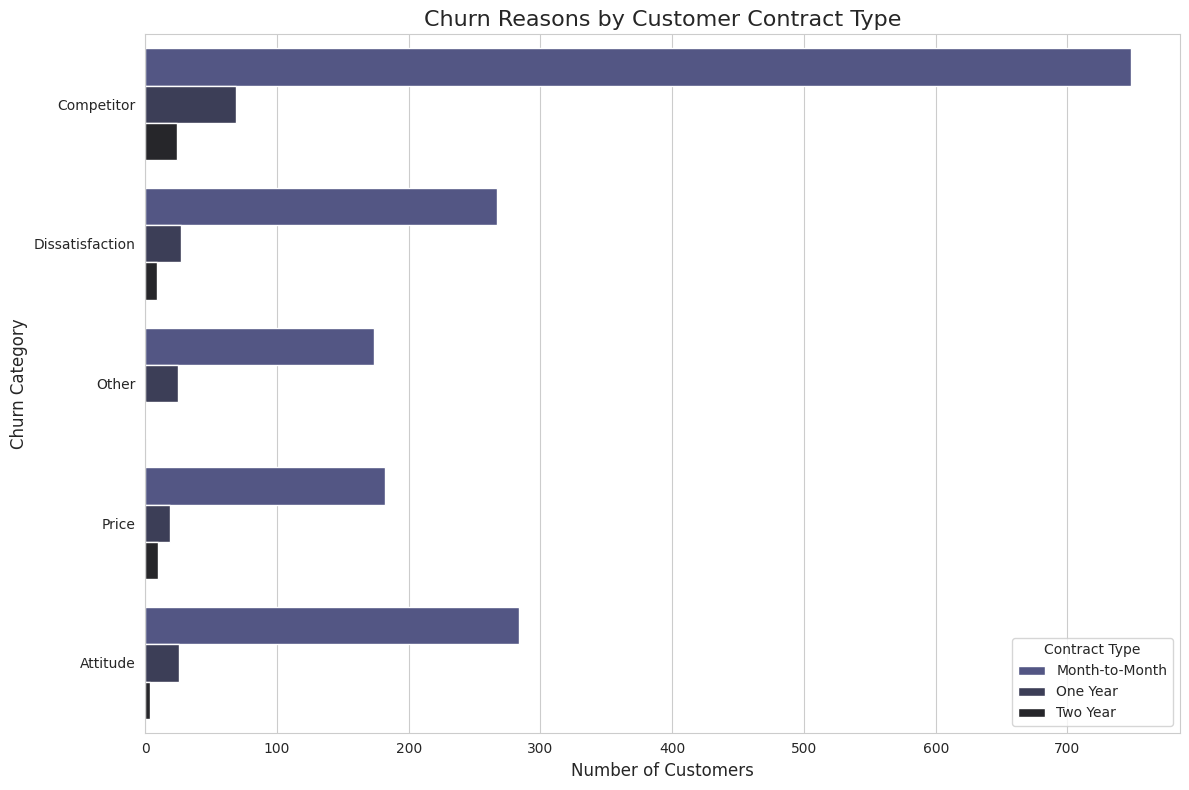

In [ ]:
# Part 2: Diagnostic Analysis (Updated Colors)

# --- Set up plot styles ---
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
primary_color = '#4B4F8C'

# --- Isolate churned customers for detailed reason analysis ---
churned_df = analysis_df[analysis_df['Churn Category'] != 'Stayed'].copy()


# --- 1. Deep Dive into Specific Churn Reasons ---
plt.figure(figsize=(12, 8))
top_15_reasons = churned_df['Churn Reason'].value_counts().nlargest(15).index
sns.countplot(data=churned_df[churned_df['Churn Reason'].isin(top_15_reasons)],
              y='Churn Reason',
              order=top_15_reasons,
              color=primary_color)
plt.title('Top 15 Specific Reasons for Customer Churn', fontsize=16)
plt.xlabel('Number of Customers', fontsize=12)
plt.ylabel('Churn Reason', fontsize=12)
plt.tight_layout()
plt.savefig('top_15_churn_reasons.png')
print("Saved top 15 churn reasons plot.")


# --- 2. Diagnose Financial Reasons for Churn ---
# Create a palette for the churn categories
category_palette = sns.light_palette(primary_color, n_colors=len(churned_df['Churn Category'].unique()), reverse=True)
plt.figure(figsize=(12, 8))
sns.boxplot(data=churned_df, x='Monthly Charge', y='Churn Category', palette=category_palette)
plt.title('Monthly Charges Distribution by Churn Category', fontsize=16)
plt.xlabel('Monthly Charge ($)', fontsize=12)
plt.ylabel('Churn Category', fontsize=12)
plt.savefig('charges_by_churn_category.png')
print("Saved monthly charges by churn category plot.")


# --- 3. Diagnose Churn Reasons by Customer Tenure ---
plt.figure(figsize=(12, 8))
sns.boxplot(data=churned_df, x='Tenure in Months', y='Churn Category', palette=category_palette)
plt.title('Customer Tenure Distribution by Churn Category', fontsize=16)
plt.xlabel('Tenure in Months', fontsize=12)
plt.ylabel('Churn Category', fontsize=12)
plt.savefig('tenure_by_churn_category.png')
print("Saved tenure by churn category plot.")


# --- 4. Diagnose Churn Reasons by Contract Type ---
# Create a palette for the contract types
contract_palette = sns.dark_palette(primary_color, n_colors=3, reverse=True)
plt.figure(figsize=(12, 8))
sns.countplot(data=churned_df, y='Churn Category', hue='Contract', palette=contract_palette)
plt.title('Churn Reasons by Customer Contract Type', fontsize=16)
plt.xlabel('Number of Customers', fontsize=12)
plt.ylabel('Churn Category', fontsize=12)
plt.legend(title='Contract Type')
plt.tight_layout()
plt.savefig('churn_reasons_by_contract.png')
print("Saved churn reasons by contract plot.")

**Key Insights from Diagnostic Analysis:**
1. Competitors are the Biggest Threat
As seen in the "Top 15 Specific Reasons" chart, the most common reasons for leaving are directly related to competitors offering better deals, better devices, or more data. This is a direct attack on your customer base.

2. Price is a Major Factor for High-Paying Customers
The box plot "Monthly Charges Distribution by Churn Category" clearly shows that customers who churn due to Price and Competitor offers have a significantly higher median monthly charge (around $70-$90) compared to those leaving for other reasons. This confirms that your highest-paying customers are the most price-sensitive and vulnerable to competitive offers.

3. Month-to-Month Contracts Offer No Protection
The "Churn Reasons by Customer Contract Type" chart is perhaps the most telling. It shows that the vast majority of churn, regardless of the reason, comes from customers on Month-to-Month contracts. This contract type provides no long-term commitment, allowing customers to leave easily the moment a better offer appears or they become dissatisfied.

4. Dissatisfaction Affects a Broad Range of Customers
While customers churning for competitive reasons tend to be newer, the "Customer Tenure Distribution" plot shows that Dissatisfaction affects customers across all tenure lengths. This indicates that service-level issues or poor support can erode loyalty even among long-term customers. The specific reason, "Attitude of support person," highlights a direct, actionable area for improvement.

Summary of Diagnosis:
Your primary churn problem is centered around price-sensitive customers on flexible month-to-month contracts being poached by competitors. A secondary, but still significant, issue is customer dissatisfaction with service and support, which can affect any customer at any time.

# **Part 3: Predictive Analysis**

--- Data prepared for modeling (Leaky features and IDs removed). ---
Features shape: (7043, 41)
Target shape: (7043,)

--- Training and evaluating models... ---
Logistic Regression - Accuracy: 0.8376
Random Forest - Accuracy: 0.8319
Gradient Boosting - Accuracy: 0.8438
Support Vector Machine - Accuracy: 0.8410

--- Best Performing Model: Gradient Boosting with an accuracy of 0.8438 ---

Classification Report for the Best Model:
              precision    recall  f1-score   support

      Stayed       0.88      0.91      0.90      1294
     Churned       0.73      0.66      0.69       467

    accuracy                           0.84      1761
   macro avg       0.80      0.79      0.79      1761
weighted avg       0.84      0.84      0.84      1761


Saved confusion matrix plot for the best model.


/tmp/ipython-input-1084087622.py:132: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_20_features, y=top_20_features.index, palette=importance_palette)


Saved feature importance plot for the best tree-based model.


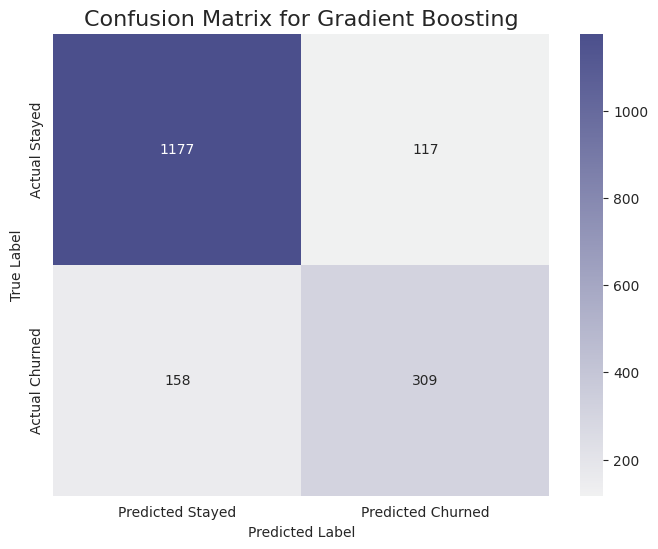

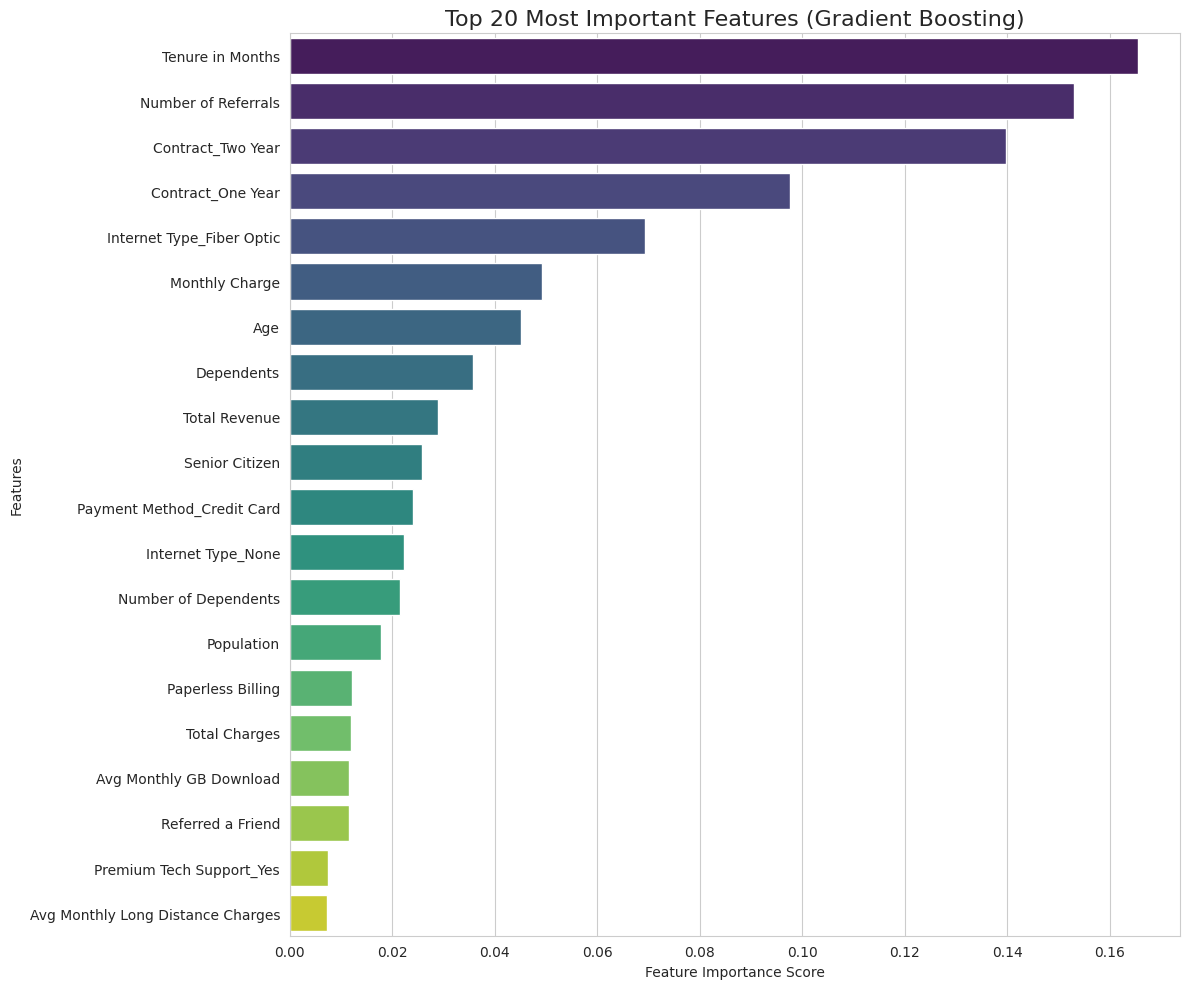

In [ ]:
# --- Part 3: Predictive Analysis (Corrected for Overfitting & Final Version) ---

# Import necessary libraries for machine learning and evaluation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# --- 1. Prepare Data for Modeling ---
# Start with the cleaned 'analysis_df' from the exploratory phase.
model_df = analysis_df.copy()

# Drop columns that would "leak" future information or are unique identifiers.
leaky_and_id_columns = [
    'CustomerID', 'City', 'Zip Code', 'Latitude', 'Longitude',
    'Churn Category', 'Churn Reason', 'Churn Score', 'Customer Status',
    'Satisfaction Score', # High potential for data leakage
    'CLTV',               # High potential for data leakage
    'Churn Label'         # Original text label for churn
]
model_df.drop(columns=leaky_and_id_columns, inplace=True, errors='ignore')

# Convert remaining categorical columns to a numerical format using one-hot encoding.
categorical_cols = model_df.select_dtypes(include=['object', 'category']).columns
model_df_encoded = pd.get_dummies(model_df, columns=categorical_cols, drop_first=True)


# --- 2. Define Features (X) and Target (y) ---
# The target variable (y) is what we want to predict: 'Churn Value'.
y = model_df_encoded['Churn Value']

# The features (X) are all other columns after dropping the target variable.
X = model_df_encoded.drop(columns=['Churn Value'])

print("--- Data prepared for modeling (Leaky features and IDs removed). ---")
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")


# --- 3. Split Data into Training and Testing Sets ---
# We use stratification to ensure the proportion of churned customers is the same in both sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)


# --- 4. Define and Train Multiple Models ---
# Create a dictionary of models to evaluate. We use a pipeline to combine scaling and modeling.
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Support Vector Machine': SVC(random_state=42, probability=True)
}

results = {}
print("\n--- Training and evaluating models... ---")

for name, model in models.items():
    # Create a pipeline that first scales the data then fits the model
    pipeline = make_pipeline(StandardScaler(), model)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy
    print(f"{name} - Accuracy: {accuracy:.4f}")


# --- 5. Compare Model Performance ---
# Find the best model based on accuracy
best_model_name = max(results, key=results.get)
best_model_accuracy = results[best_model_name]

print(f"\n--- Best Performing Model: {best_model_name} with an accuracy of {best_model_accuracy:.4f} ---")


# --- 6. In-Depth Evaluation of the Best Model ---
# Re-train the best model pipeline to generate a detailed report and visualizations
best_model_pipeline = make_pipeline(StandardScaler(), models[best_model_name])
best_model_pipeline.fit(X_train, y_train)
y_pred_best = best_model_pipeline.predict(X_test)

print("\nClassification Report for the Best Model:")
print(classification_report(y_test, y_pred_best, target_names=['Stayed', 'Churned']))

# --- 7. Visualizations with Updated Colors ---

# Define the primary color for visualizations
primary_color = '#4B4F8C'
# Create a custom colormap for the heatmap from the primary color
custom_cmap_blues = sns.light_palette(primary_color, as_cmap=True)

# Visualize the Confusion Matrix for the best model
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap=custom_cmap_blues,
            xticklabels=['Predicted Stayed', 'Predicted Churned'],
            yticklabels=['Actual Stayed', 'Actual Churned'])
plt.title(f'Confusion Matrix for {best_model_name}', fontsize=16)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('confusion_matrix_best_model.png')
print("\nSaved confusion matrix plot for the best model.")


# --- 8. Analyze and Plot Feature Importance ---
# Select the best tree-based model (Random Forest or Gradient Boosting) to show feature importances
best_tree_model = None
tree_models = {name: model for name, model in models.items() if hasattr(model, 'feature_importances_')}

if tree_models:
    best_tree_model_name = max(tree_models, key=lambda name: results[name])
    best_tree_model = tree_models[best_tree_model_name]

    # We fit the model directly (without scaling) to easily extract feature importances
    # This is acceptable for tree models and gives a direct feature-to-importance mapping
    best_tree_model.fit(X_train, y_train)

    # **THIS IS WHERE THE TOP 20 FEATURES ARE CALCULATED**
    feature_importances = pd.Series(best_tree_model.feature_importances_, index=X.columns)
    top_20_features = feature_importances.nlargest(20)

    # Create a sequential palette for the feature importances
    importance_palette = sns.color_palette("viridis", n_colors=20)

    plt.figure(figsize=(12, 10))
    sns.barplot(x=top_20_features, y=top_20_features.index, palette=importance_palette)
    plt.title(f'Top 20 Most Important Features ({best_tree_model_name})', fontsize=16)
    plt.xlabel('Feature Importance Score')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.savefig('feature_importance_best_model.png')
    print("Saved feature importance plot for the best tree-based model.")

# **Part 4: Prescriptive Analysis (Actionable Recommendations)**

This final step doesn't involve new code. It's about translating all of our findings (from EDA, Diagnostics, and Predictions) into a strategic action plan.

1. Target Month-to-Month Customers Immediately:

Problem: These customers are the most likely to churn.

Prescription: Proactively contact these customers with exclusive offers to switch to a One or Two-Year contract. Highlight the benefits of long-term plans, such as price stability, discounts, or bundled services. Even a small discount now is better than losing the customer entirely.

2. Develop a Competitive Retention Strategy:

Problem: The number one reason for churn is competitors.

Prescription: Implement a "competitor response" program. When a high-risk customer (identified by our predictive model) calls to cancel, empower retention agents to match or beat competitor offers, especially regarding data allowances or pricing for Fiber Optic plans.

3. Launch a Loyalty Program for New Customers:

Problem: Customers with low tenure are at high risk.

Prescription: Create a loyalty program that rewards customers for staying. This could include a small discount after 6 months, a free service add-on after 9 months, or a device upgrade credit after a year. The goal is to get them past the vulnerable early stages and integrated into the ecosystem.

4. Improve the Onboarding and Support Experience:

Problem: Dissatisfaction with service and support is a key driver of churn.

Prescription: Invest in training for customer support staff, focusing on attitude and first-call resolution. For new customers, implement a structured onboarding process that includes a welcome call, service check-up, and a tutorial on how to get the most out of their plan.

# **Interactive Dashboard:**

In [ ]:
# Step 1: Install all necessary libraries
!pip install streamlit pandas plotly openpyxl -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 60.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 118.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 7.8 MB/s eta 0:00:00


In [ ]:
# Step 2: Write the Streamlit app code to a file named 'dashboard.py'
%%writefile dashboard.py
import streamlit as st
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

# --- Page Configuration ---
st.set_page_config(
    page_title="Telco Customer Churn Dashboard",
    page_icon="📊",
    layout="wide"
)

# --- Custom Color Palette ---
COLOR_CHURNED = "#4B4F8C"  # Deep Indigo
COLOR_STAYED = "#D5D3F0"   # Lavender
COLOR_MAP_CHURN = {'Yes': COLOR_CHURNED, 'No': COLOR_STAYED}

# --- Data Loading and Caching ---
@st.cache_data
def load_and_prepare_data():
    """
    Loads, merges, cleans, and engineers features for the Telco churn data.
    """
    try:
        demographics_df = pd.read_excel('Telco_customer_churn_demographics.xlsx')
        location_df = pd.read_excel('Telco_customer_churn_location.xlsx')
        population_df = pd.read_excel('Telco_customer_churn_population.xlsx')
        services_df = pd.read_excel('Telco_customer_churn_services.xlsx')
        status_df = pd.read_excel('Telco_customer_churn_status.xlsx')
    except FileNotFoundError:
        st.error("One or more data files not found. Please ensure all .xlsx files are in the same directory as the script.")
        return None

    # Standardize column names for merging
    for df in [demographics_df, location_df, services_df, status_df]:
        df.rename(columns={'Customer ID': 'CustomerID'}, inplace=True)

    # Pre-merge cleaning
    demographics_df.drop(columns=['Count', 'Under 30'], inplace=True, errors='ignore')
    location_df.drop(columns=['Count'], inplace=True, errors='ignore')
    services_df.drop(columns=['Count', 'Quarter'], inplace=True, errors='ignore')
    status_df.drop(columns=['Count', 'Quarter'], inplace=True, errors='ignore')

    # Merge all dataframes
    merged_df = pd.merge(demographics_df, location_df, on='CustomerID', how='outer')
    merged_df = pd.merge(merged_df, services_df, on='CustomerID', how='outer')
    merged_df = pd.merge(merged_df, status_df, on='CustomerID', how='outer')
    merged_df = pd.merge(merged_df, population_df, on='Zip Code', how='left')

    # Final cleaning and preparation
    analysis_df = merged_df.copy()
    analysis_df.drop_duplicates(subset='CustomerID', keep='first', inplace=True)
    analysis_df['Churn Category'].fillna('Stayed', inplace=True)
    analysis_df['Churn Label'].fillna('No', inplace=True)
    analysis_df['Internet Type'].fillna('None', inplace=True)
    analysis_df['Total Charges'] = pd.to_numeric(analysis_df['Total Charges'], errors='coerce').fillna(0)
    analysis_df['Churn Value'] = analysis_df['Churn Label'].apply(lambda x: 1 if x == 'Yes' else 0)

    # Feature Engineering for Number of Services
    service_columns = [
        'Phone Service', 'Multiple Lines', 'Online Security', 'Online Backup',
        'Device Protection Plan', 'Premium Tech Support', 'Streaming TV',
        'Streaming Movies', 'Streaming Music', 'Unlimited Data'
    ]

    temp_df = analysis_df.copy()
    for col in service_columns:
        if col in temp_df.columns:
            temp_df[col] = (temp_df[col] == 'Yes').astype(int)

    analysis_df['NumberOfServices'] = temp_df[service_columns].sum(axis=1)
    analysis_df['NumberOfServices'] += (analysis_df['Internet Service'] != 'No').astype(int)

    return analysis_df

# Load the data
df = load_and_prepare_data()

if df is not None:
    # --- Dashboard Title ---
    st.title("📊 Telco Customer Churn Analysis")
    st.markdown("An interactive dashboard to explore the factors influencing customer churn.")

    # --- Sidebar for Filters ---
    st.sidebar.header("Filters")
    contract_options = df['Contract'].unique().tolist()
    selected_contracts = st.sidebar.multiselect("Filter by Contract Type", options=contract_options, default=contract_options)
    internet_options = df['Internet Type'].unique().tolist()
    selected_internet = st.sidebar.multiselect("Filter by Internet Type", options=internet_options, default=internet_options)

    # Filter the dataframe based on selections
    filtered_df = df[
        df['Contract'].isin(selected_contracts) &
        df['Internet Type'].isin(selected_internet)
    ]

    # --- Key Metrics (KPIs) ---
    st.header("Overall Churn Metrics")
    col1, col2, col3 = st.columns(3)
    total_customers = filtered_df.shape[0]
    churned_customers = filtered_df['Churn Value'].sum()
    churn_rate = (churned_customers / total_customers) * 100 if total_customers > 0 else 0
    col1.metric("Total Customers", f"{total_customers:,}")
    col2.metric("Churned Customers", f"{churned_customers:,}")
    col3.metric("Churn Rate", f"{churn_rate:.2f}%")

    st.markdown("---")

    # --- Visualizations ---
    st.header("Exploratory Data Analysis")

    viz_col1, viz_col2 = st.columns(2)

    with viz_col1:
        # 1. Main Reasons for Churn
        churn_reasons_df = filtered_df[filtered_df['Churn Category'] != 'Stayed']
        churn_reasons_counts = churn_reasons_df['Churn Category'].value_counts().reset_index()
        churn_reasons_counts.columns = ['Churn Category', 'Count']
        fig_reasons = px.bar(
            churn_reasons_counts,
            x='Count',
            y='Churn Category',
            orientation='h',
            title="Top Reasons for Customer Churn",
            labels={'Count': 'Number of Customers', 'Churn Category': 'Reason'}
        )
        fig_reasons.update_traces(marker_color=COLOR_CHURNED)
        fig_reasons.update_layout(yaxis={'categoryorder':'total ascending'})
        st.plotly_chart(fig_reasons, use_container_width=True)

    with viz_col2:
        # 2. Churn by Contract Type
        churn_by_contract = filtered_df.groupby(['Contract', 'Churn Label']).size().reset_index(name='Count')
        fig_contract = px.bar(
            churn_by_contract,
            x='Contract',
            y='Count',
            color='Churn Label',
            barmode='group',
            title="Churn Distribution by Contract Type",
            color_discrete_map=COLOR_MAP_CHURN
        )
        st.plotly_chart(fig_contract, use_container_width=True)

    viz_col3, viz_col4 = st.columns(2)

    with viz_col3:
        # 3. Churn by Internet Type
        churn_by_internet = filtered_df.groupby(['Internet Type', 'Churn Label']).size().reset_index(name='Count')
        fig_internet = px.bar(
            churn_by_internet,
            x='Internet Type',
            y='Count',
            color='Churn Label',
            barmode='group',
            title="Churn Distribution by Internet Type",
            color_discrete_map=COLOR_MAP_CHURN
        )
        st.plotly_chart(fig_internet, use_container_width=True)

    with viz_col4:
        # 4. Churn by Dependents
        churn_by_dependents = filtered_df.groupby(['Dependents', 'Churn Label']).size().reset_index(name='Count')
        fig_dependents = px.bar(
            churn_by_dependents,
            x='Dependents',
            y='Count',
            color='Churn Label',
            barmode='group',
            title="Churn Distribution by Dependents",
            color_discrete_map=COLOR_MAP_CHURN
        )
        st.plotly_chart(fig_dependents, use_container_width=True)

    # 5. Churn Rate by Number of Services (Full Width)
    st.markdown("### Churn Rate by Number of Services Subscribed")
    services_churn = filtered_df.groupby('NumberOfServices')['Churn Value'].mean().reset_index()
    services_churn['Churn Rate'] = services_churn['Churn Value'] * 100
    fig_services = px.bar(
        services_churn,
        x='NumberOfServices',
        y='Churn Rate',
        title="Churn Rate vs. Number of Services",
        labels={'NumberOfServices': 'Total Number of Services', 'Churn Rate': 'Churn Rate (%)'}
    )
    fig_services.update_traces(marker_color=COLOR_CHURNED)
    st.plotly_chart(fig_services, use_container_width=True)

    st.markdown("---")
    st.header("Financial and Tenure Analysis")
    viz_col5, viz_col6 = st.columns(2)

    with viz_col5:
        # 6. Distribution of Monthly Charges
        fig_monthly_charges = px.histogram(
            filtered_df,
            x='Monthly Charge',
            color='Churn Label',
            marginal='box',
            title="Distribution of Monthly Charges by Churn Status",
            color_discrete_map=COLOR_MAP_CHURN
        )
        st.plotly_chart(fig_monthly_charges, use_container_width=True)

    with viz_col6:
        # 7. Distribution of Customer Tenure
        fig_tenure = px.histogram(
            filtered_df,
            x='Tenure in Months',
            color='Churn Label',
            marginal='box',
            title="Distribution of Customer Tenure by Churn Status",
            color_discrete_map=COLOR_MAP_CHURN
        )
        st.plotly_chart(fig_tenure, use_container_width=True)

    st.markdown("---")
    st.header("Customer Data Explorer")
    st.dataframe(filtered_df)

else:
    st.warning("Data could not be loaded. Please check the file paths and try again.")

Writing dashboard.py


In [ ]:
# Step 3: Download cloudflared, run the app, and start the tunnel (Reliable Method)
import subprocess
import time
import re

# Download and make cloudflared executable
!wget -q -O cloudflared https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64
!chmod +x cloudflared

print("✅ 'dashboard.py' created and cloudflared downloaded.")
print("🚀 Starting dashboard and tunnel...")

# Run Streamlit in the background
process = subprocess.Popen(['streamlit', 'run', 'dashboard.py', '--server.port', '8501'])

# Give Streamlit a moment to start up
time.sleep(5)

# Run cloudflared to create the tunnel and log output
tunnel_process = subprocess.Popen(
    ['./cloudflared', 'tunnel', '--url', 'http://localhost:8501'],
    stdout=subprocess.PIPE,
    stderr=subprocess.STDOUT,
    universal_newlines=True
)

# Wait for the tunnel to establish and print the URL
public_url = ""
for i in range(10): # Try for 10 seconds
    line = tunnel_process.stdout.readline()
    url_match = re.search(r"https?://[a-zA-Z0-9-]+\.trycloudflare\.com", line)
    if url_match:
        public_url = url_match.group(0)
        print("\n" + "="*50)
        print(f"🎉 Your Streamlit dashboard is live at: {public_url}")
        print("="*50 + "\n")
        break
    time.sleep(1)

# If the URL wasn't found, print a message
if not public_url:
    print(" Tunnel URL not found. Please check the logs.")

# Keep the cell running to keep the tunnel alive
tunnel_process.wait()

✅ 'dashboard.py' created and cloudflared downloaded.
🚀 Starting dashboard and tunnel...

🎉 Your Streamlit dashboard is live at: https://archived-estimate-collection-depth.trycloudflare.com



KeyboardInterrupt: 